# Super Resolution Training Notebook

The Super Resolution model is a U-Net model trained on a subset of the Open Images dataset. This notebook details preparing the data and training the model.

In [1]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *

from torchvision.models import vgg16_bn

In [2]:
from PIL import ImageDraw, ImageFont
import string

The dataset contains 200,000 full size images

In [3]:
path = Path('F:/Open_Images')
path_hr = path/'train_00'
path_lr = path/'train_00_128'

In [4]:
il = ImageItemList.from_folder(path_hr)

In [4]:
il[:1000].items

array([WindowsPath('F:/Kaggle Object/train_00/dec2aafe511bcd90.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dec2addd03e136f4.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dec2af37391d4765.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dec2b430d7bee838.jpg'), ...,
       WindowsPath('F:/Kaggle Object/train_00/dee971e782fa8685.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dee9766b086b9d38.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dee984de34238a66.jpg'),
       WindowsPath('F:/Kaggle Object/train_00/dee98ffe66403b0d.jpg')], dtype=object)

In [5]:
len(il.items)

200000

Input data for the model is a 128x128 image. The model outputs a 256x256 image. Input images are created by scaling an entire image down to 128 and saving at a quality level of 60. Ground Truth images of size 256x256 will be created by the dataloader during the training process.

In [5]:
def resize_one(fn):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, 128, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img.save(dest, quality=60)

In [6]:
def parallel_func(func, arr):
    with ThreadPoolExecutor(8) as ex:
        futures = ex.map(lambda x: func(x), arr)

In [10]:
parallel_func(resize_one, il.items)

A subset of images were augmented with text. Originally I wanted to create an augmentation function that would add text on the fly, but I found this resulted in low resolution images getting augmented with high resolution text. To ensure the resolution of text in the 128x128 input images was at the proper resolution, I created a static set of 50,000 text augmented images.

In [7]:
def textify(pil_img):
    
    w,h = pil_img.size
    text_loc = (random.randint(0,w//2),random.randint(0,h//2))
    text_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
    text_length = random.randint(0,300)
    text = ''.join([random.sample(string.printable, 1)[0]+random.sample(string.ascii_letters, 1)[0]
                                        for i in range(text_length)])
    text_size = random.randint(10,60)
    font = ImageFont.truetype("arial.ttf", text_size)
    ImageDraw.Draw(pil_img).text(text_loc, text, fill=text_color, font=font)
    
    return pil_img

In [8]:
def textify_one(fn):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('RGB')
    
    img_txt = textify(img)
    img_txt.save(Path(str(fn).split('.')[0] + '_text.jpg'), quality=100)
    
    targ_sz = resize_to(img_txt, 128, use_min=True)
    img_txt = img_txt.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    img_txt.save(Path(str(dest).split('.')[0] + '_text.jpg'), quality=60)

In [9]:
parallel_func(textify_one, il.items[:50000])

This creates the dataloader

In [5]:
bs,size=9,256
arch = models.resnet34

src = ImageImageList.from_folder(path_lr).random_split_by_pct(0.05, seed=42)

In [6]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [7]:
data = get_data(bs,size)

Example input and output images

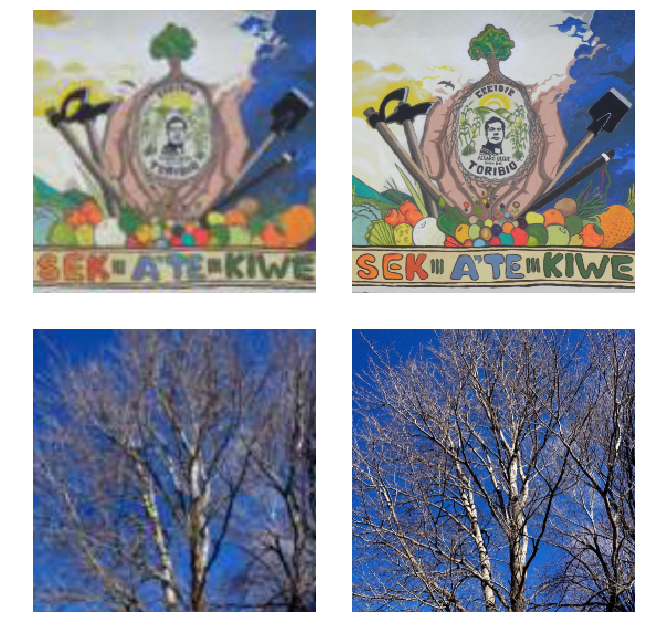

In [14]:
data.show_batch(ds_type=DatasetType.Valid, rows=2, figsize=(9,9))

# Perceptual Loss

The model is trained on a loss function composed of three elements - L1 loss, perceptual loss (arxiv.org/abs/1603.08155) and an L2-Wasserstein loss (github.com/VinceMarron/style_transfer).

This model uses a pretrained VGG16 network as a feature extractor.

In [8]:
base_loss = F.l1_loss

In [9]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [10]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [11]:
x = torch.rand([32, 256, 1024], device=0, requires_grad=True)

In [13]:
(x@x.transpose(1,2)).shape

torch.Size([32, 256, 256])

In [14]:
lr = 1e-3

# Wasserstein Loss

Calculation of the L2-Wasserstein metric

In [15]:
def calc_2_moments(tensor):
    chans = tensor.shape[1]
    tensor = tensor.view(1, chans, -1)
    n = tensor.shape[2]
    
    mu = tensor.mean(2)
    tensor = (tensor - mu[:,:,None]).squeeze(0)
    cov = torch.mm(tensor, tensor.t()) / float(n)
    
    return mu, cov

In [16]:
def get_style_vals(tensor):
    mean, cov = calc_2_moments(tensor)
    
    eigvals, eigvects = torch.symeig(cov, eigenvectors=True)
    
    eigroot_mat = torch.diag(torch.sqrt(eigvals.clamp(min=0)))
    
    root_cov = torch.mm(torch.mm(eigvects, eigroot_mat), eigvects.t())
    
    tr_cov = eigvals.clamp(min=0).sum()
    
    return mean, tr_cov, root_cov

In [17]:
def calc_l2wass_dist(mean_stl, tr_cov_stl, root_cov_stl, mean_synth, cov_synth):
    
    tr_cov_synth = torch.symeig(cov_synth, eigenvectors=True)[0].clamp(min=0).sum()
    
    mean_diff_squared = (mean_stl - mean_synth).pow(2).sum()
    
    cov_prod = torch.mm(torch.mm(root_cov_stl, cov_synth), root_cov_stl)
    
    var_overlap = torch.sqrt(torch.symeig(cov_prod, eigenvectors=True)[0].clamp(min=0)+1e-8).sum()
    
    dist = mean_diff_squared + tr_cov_stl + tr_cov_synth - 2*var_overlap
    
    return dist

In [18]:
def single_wass_loss(pred, targ):
    mean_test, tr_cov_test, root_cov_test = targ
    mean_synth, cov_synth = calc_2_moments(pred)
    loss = calc_l2wass_dist(mean_test, tr_cov_test, root_cov_test, mean_synth, cov_synth)
    return loss

# SR Unet

Full loss function:

In [19]:
class FeatureLoss_Wass(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts, wass_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.wass_wgts = wass_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'wass_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        
        styles = [get_style_vals(i) for i in out_feat]
        self.feat_losses += [single_wass_loss(f_pred, f_targ)*w
                            for f_pred, f_targ, w in zip(in_feat, styles, self.wass_wgts)]
        
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

`blocks` denotes what layers of the VGG16 network will be used in the loss calculation

`layer_wgts` are the weights applied to the perceptual loss calculations

`wass_wgts` are the weights applied to the L2-Wasserstein calculations

Deciding what layers and weight values to use are hyperparameters that must be determined experimentally. I have found that using 3 layers, weighted such that each layer contribution is about 0.1-0.2, works well.

In [20]:
feat_loss = FeatureLoss_Wass(vgg_m, blocks[2:5], [5,15,2], [3, 0.7, 0.01])

In [21]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


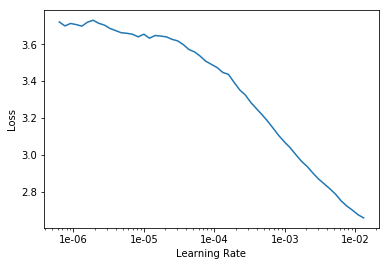

In [34]:
learn.lr_find()
learn.recorder.plot()

In [21]:
def do_fit(save_name, epochs, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)

In [22]:
lr = 1e-3

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,wass_0,wass_1,wass_2
1,1.103385,1.009323,0.151931,0.229851,0.254981,0.100240,0.120834,0.086218,0.065269


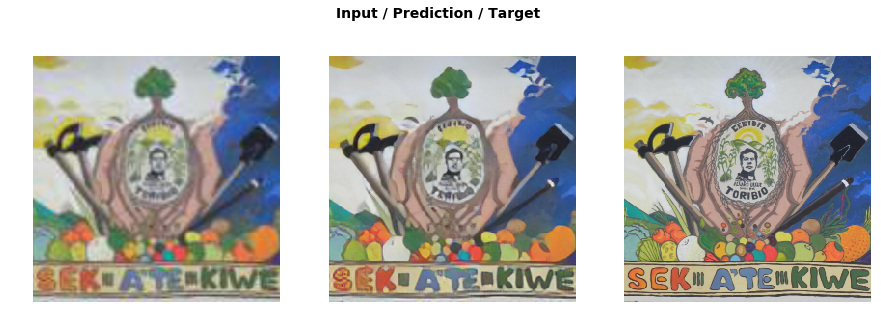

In [38]:
do_fit('obj1', 1, slice(lr*10))

In [39]:
learn.unfreeze()

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,wass_0,wass_1,wass_2
1,1.090124,0.995392,0.151060,0.228350,0.252771,0.099464,0.115918,0.083907,0.063922


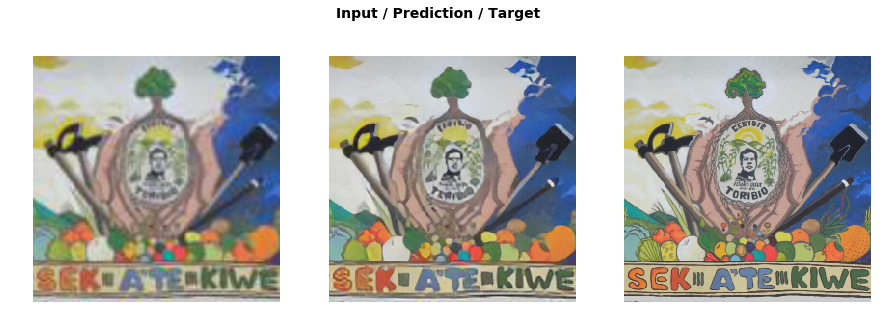

In [46]:
do_fit('obj2', 1, slice(5e-6,5e-4), pct_start=0.3)

In [24]:
learn.save('obj2');

In [22]:
learn.load('obj2');

In [23]:
learn.export('obj2_ex')

C:\Users\GATEWAY\Anaconda2\envs\fastai_v1\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type FeatureLoss_Wass. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
